## Training Notebook

Define and train an RNN in Tensorflow. This model evaluates spamminess by message, i.e. each message is considered independent of all others.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import hashlib
import unicodedata
import re
import string
import itertools

from tensorflow import set_random_seed

# Set random seeds for reproducible results
np.random.seed(42)
set_random_seed(42)

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

# Rough proportion of data in training set
train_split = 0.7
# Max character length of a message, hardcoded in OSRS as 80 chars
max_chars = 80
# Threshold above which a message is classed as spam
spam_thresh = 0.50

# Get rid of pandas warning
pd.options.mode.chained_assignment = None

tf.__version__

'1.13.0-rc2'

In [38]:
# Load and deduplicate the dataset

df = pd.read_csv("dataset.csv", index_col=0)
df = df.drop_duplicates('message').reset_index(drop=True)

In [39]:
# Split the dataset by user, using MD5 hash to make splitting deterministic and repeatable after adding new data
# The split proportion won't be exactly as specified, but it'll be good enough

split_val = (2 ** 128 - 1) * train_split
df['usermd5'] = [int(hashlib.md5(user.encode("utf-8")).hexdigest(), 16) for user in df['user']]
traindf = df[df['usermd5'] < split_val]
testdf = df[df['usermd5'] > split_val]
df.drop(columns=['usermd5'], inplace=True)
traindf.drop(columns=['usermd5'], inplace=True)
testdf.drop(columns=['usermd5'], inplace=True)

# Clean message function. Remove punctuation, repeated whitespace, and convert everything to lowercase
# We don't tokenize by words, instead just use ascii encoding
def clean_message(msg):
    #msg = msg.translate(str.maketrans('', '', string.punctuation))
    #msg = msg.lower()
    #msg = re.sub(' +', ' ', msg)
    return unicodedata.normalize('NFKD', msg).encode('ascii','ignore')
    
# Messages are short enough that we probably don't need to tokenize by words

encoded_msgs = [list(clean_message(msg)) for msg in np.array(df['message'])]
seqs = pad_sequences(encoded_msgs, maxlen=max_chars)
seqs = seqs.reshape((len(seqs), max_chars, 1))

msg_train = traindf['message']
msg_test = testdf['message']

X_train = seqs[traindf.index]
X_test = seqs[testdf.index]

Y_train = np.array(traindf['spam'])
Y_test = np.array(testdf['spam'])

print("Proportion of data in train set: {}".format(len(X_train) / (len(X_train) + len(X_test))))
print("Proportion of data in test set: {}".format(len(X_test) / (len(X_train) + len(X_test))))

Proportion of data in train set: 0.7127465857359636
Proportion of data in test set: 0.28725341426403644


In [40]:
# Define Keras model constructor
# Model archetecture:
# Input layer of length 80
# Hidden LSTM layer
# Hidden dense layer
# Output layer, FC with sigmoid activation

def create_model(l1=64, d1=32):
    inputs = Input(shape=(max_chars,1))
    X = Bidirectional(LSTM(l1))(inputs)
    X = Dense(d1, activation='relu')(X)
    output = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc', Precision(name='precision'), Recall(name='recall')])
    return model

In [ ]:
# Train the model, checking performance on validation set. 
# Model tends to converge before around 25 epochs with batch size of 128.
# Training takes about 1 minute on an i3.

model = create_model(l1=96, d1=16)

history = model.fit(
    X_train, 
    Y_train, 
    epochs=15, 
    validation_data=(X_test, Y_test), 
    batch_size=64, 
    verbose=2)

K.set_learning_phase(0)

Train on 4697 samples, validate on 1893 samples
Epoch 1/15
 - 26s - loss: 0.2021 - acc: 0.9493 - precision: 0.7486 - recall: 0.6317 - val_loss: 0.0492 - val_acc: 0.9852 - val_precision: 0.7176 - val_recall: 0.9385
Epoch 2/15
 - 25s - loss: 0.0703 - acc: 0.9776 - precision: 0.8784 - recall: 0.8634 - val_loss: 0.0305 - val_acc: 0.9905 - val_precision: 0.8052 - val_recall: 0.9538
Epoch 3/15
 - 26s - loss: 0.0561 - acc: 0.9819 - precision: 0.9288 - recall: 0.8585 - val_loss: 0.0446 - val_acc: 0.9889 - val_precision: 0.7750 - val_recall: 0.9538
Epoch 4/15
 - 20s - loss: 0.0494 - acc: 0.9836 - precision: 0.9562 - recall: 0.8512 - val_loss: 0.0331 - val_acc: 0.9910 - val_precision: 0.8158 - val_recall: 0.9538
Epoch 5/15
 - 25s - loss: 0.0479 - acc: 0.9851 - precision: 0.9521 - recall: 0.8732 - val_loss: 0.0377 - val_acc: 0.9921 - val_precision: 0.8378 - val_recall: 0.9538
Epoch 6/15
 - 20s - loss: 0.0421 - acc: 0.9870 - precision: 0.9629 - recall: 0.8854 - val_loss: 0.0302 - val_acc: 0.9937 -

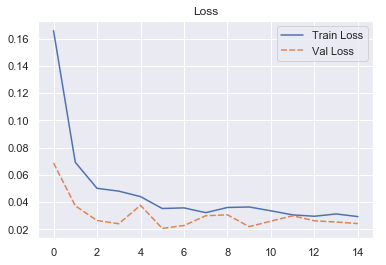

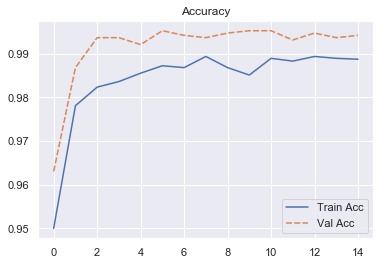

In [42]:
sns.lineplot(
    data=pd.DataFrame({'Train Loss': history.history['loss'], 'Val Loss': history.history['val_loss']})
).set_title('Loss')
plt.show()

sns.lineplot(
    data=pd.DataFrame({'Train Acc': history.history['acc'], 'Val Acc': history.history['val_acc']})
).set_title('Accuracy')
plt.show()

In [43]:
# Make predictions on entire dataset and re-split into test and train sets

allpreds = model.predict(seqs)

df['pred'] = allpreds
df['predclass'] = allpreds > spam_thresh
testdf = df.iloc[testdf.index]
traindf = df.iloc[traindf.index]

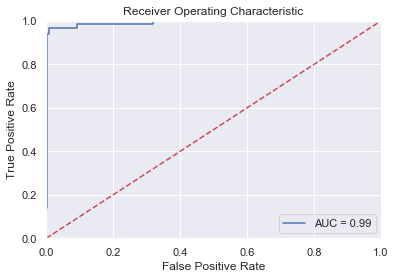

In [44]:
fpr, tpr, threshold = roc_curve(Y_test, testdf['pred'])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5, 1.0, 'Test set confusion matrix')

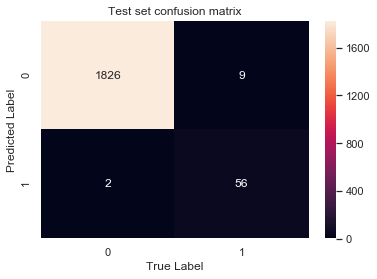

In [45]:
# Test set confusion matrix and misclassified examples

conf = confusion_matrix(testdf['predclass'], testdf['spam'])
fig = sns.heatmap(conf, annot=True, fmt='d')
fig.set_xlabel("True Label")
fig.set_ylabel("Predicted Label")
fig.set_title("Test set confusion matrix")

Text(0.5, 1.0, 'Train set confusion matrix')

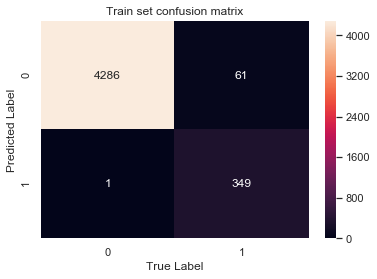

In [46]:
# Training set confusion matrix and misclassified examples

conf = confusion_matrix(traindf['predclass'], traindf['spam'])
fig = sns.heatmap(conf, annot=True, fmt='g')
fig.set_xlabel("True Label")
fig.set_ylabel("Predicted Label")
fig.set_title("Train set confusion matrix")

In [20]:
# Show misclassified test and train samples

display(testdf[testdf['spam'] != testdf['predclass']])
display(traindf[traindf['spam'] != traindf['predclass']])

,user,message,spam,pred,predclass
151,TheSlaybodyz,5Giving away 3M on Twitch! @Slaybodyz - Get h...,False,0.933192,True
191,TheSlaybodyz,Giving away 3M on Twitch! @Slaybodyz - Get he...,False,0.830629,True
373,<img=10>IT InfoSec,"Ha. If only, jdtm, then I would be selling stu...",False,0.821198,True
662,drops baby,3Bill Drop Party world 337 Varrock Big Bank (...,False,0.984102,True
1028,ZavosofZona,Selling 100k chaos 28k laws 25k cballs 575k fe...,False,0.961309,True
1206,Pikud,Trading up 1 oak log [30gp] ( streaming road t...,False,0.774865,True
1215,skillerbrbke,Quiiting rs giving 10 precent what you show in...,True,0.001308,False
1226,BulkSelling,"Selling 58M feathers 3.5ea, 1.8M burnt food 55...",False,0.887090,True
2403,BlacKatakuri,Selling eggs 1250 each!!!!!!!!!!!!!!!!!,False,0.617675,True
3159,x Kadri 43 x,Buying death runes!!!!!!!!!!!!!!!!!!!!!,False,0.525869,True


,user,message,spam,pred,predclass
89,Kinglink34,Drop party!!!!!!!!!!!!!!!!!!!!!!!!!!!!!,False,0.533333,True
101,Kinglink34,Drop party!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!,False,0.668730,True
119,Ix2YourStack,Doubling Cash~!~!,True,0.026194,False
195,Ix2YourStack,50K Taken~!~!,True,0.041427,False
201,Ix2YourStack,100K Given~!~!,True,0.071857,False
345,RNG 2403,Blunt Joints has been paid: 600K!,True,0.457659,False
631,StupidBrain,"He has 2,147 million worth of platnium token @...",False,0.999820,True
1024,Hollywood Fl,Need a clan? Want to raid? Want to boss? -=mai...,False,0.785977,True
1126,qdad,0m each Search on youtube Eum582 To Win9237,True,0.479749,False
1196,Toripolliisi,"Make 100k+ really easy! Buy me 15k law runes, ...",False,0.851224,True


In [18]:
# Test cumulative spamminess of a user

users = {}
spampred = []

for idx, row in testdf.iterrows():
    prior, num = users.get(row['user'], (1 - spam_thresh, 1))
    spampred.append(row['pred'] > 1 - prior)
    users[row['user']] = ((prior * num + row['pred']) / (num + 1), num + 1)
    
testdf['cumulativespam'] = spampred

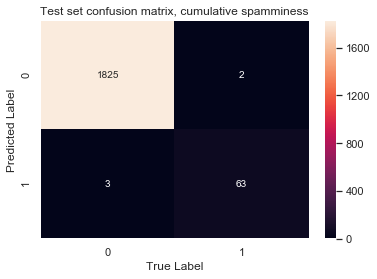

,user,message,spam,pred,predclass,cumulativespam
662,drops baby,3Bill Drop Party world 337 Varrock Big Bank (...,False,0.952456,True,True
1215,skillerbrbke,Quiiting rs giving 10 precent what you show in...,True,0.000532,False,False
5118,Vileos,??????????????????????????????????????????????...,False,0.983561,True,True
5127,Vileos,??????????????????????????????????????????????...,False,0.994555,True,True
6486,Vetiica,Join [-Chatswap-] Cc Free 200k 4 Joining + Hou...,True,0.075495,False,False


In [19]:
conf = confusion_matrix(testdf['cumulativespam'], testdf['spam'])
fig = sns.heatmap(conf, annot=True, fmt='g')
fig.set_xlabel("True Label")
fig.set_ylabel("Predicted Label")
fig.set_title("Test set confusion matrix, cumulative spamminess")
plt.show()

testdf[testdf['spam'] != testdf['cumulativespam']]

In [20]:
# Save as before, only on the training set

users = {}
spampred = []

for idx, row in traindf.iterrows():
    prior, num = users.get(row['user'], (1 - spam_thresh, 1))
    spampred.append(row['pred'] > 1 - prior)
    users[row['user']] = ((prior * num + row['pred']) / (num + 1), num + 1)
    
traindf['cumulativespam'] = spampred

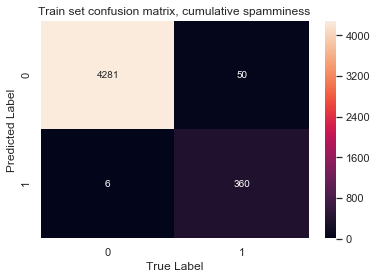

,user,message,spam,pred,predclass,cumulativespam
119,Ix2YourStack,Doubling Cash~!~!,True,0.008915,False,False
195,Ix2YourStack,50K Taken~!~!,True,0.012613,False,False
201,Ix2YourStack,100K Given~!~!,True,0.017685,False,False
339,RNG 2403,Blunt Joints has won [600K] with a roll of [87]!,True,0.152525,False,False
345,RNG 2403,Blunt Joints has been paid: 600K!,True,0.206368,False,False
419,Bettygodzj,"""Grandrolling"" Cc | Dice Game & Trusted Ranks ...",True,0.442398,False,False
631,StupidBrain,"He has 2,147 million worth of platnium token @...",False,0.875492,True,True
906,Hingle26,Join [Chatswap] Cc to Swap Your 07/Rs3 Gold!,True,0.250275,False,False
909,Hingle26,Join | Chatswap | Cc To Chat And Swap Your Gp!,True,0.048918,False,False
912,Hingle26,Join [-Chatswap-] Cc For Daily Drop Parties/Gi...,True,0.156960,False,False


In [21]:
conf = confusion_matrix(traindf['cumulativespam'], traindf['spam'])
fig = sns.heatmap(conf, annot=True, fmt='g')
fig.set_xlabel("True Label")
fig.set_ylabel("Predicted Label")
fig.set_title("Train set confusion matrix, cumulative spamminess")
plt.show()

traindf[traindf['spam'] != traindf['cumulativespam']]

In [22]:
# Save the model
model.save("antispam.h5")

In [23]:
model = load_model("antispam.h5")

In [24]:
# Saves model as .txt files for loading in Java

for layer in model.layers:
    config = layer.get_config()
    allweights = layer.get_weights()
    name = config["name"]
    for i, weights in enumerate(allweights):
        np.savetxt("model_weights/{}_params_{}.txt".format(name, i), weights)